# Домашнее задание 2 по обработке текстов

Рассмотрим задачу бинарной классификации. Пусть дано два списка имен: мужские и женские имена. Требуется разработать классификатор, который по данному имени будет определять мужское оно или женское.

Данные: 
* Женские имена: female.txt
* Мужские имена: male.txt

## Часть 1. Предварительная обработка данных

1. Удалите неоднозначные имена (те имена, которые являются и мужскими, и женскими дновременно), если такие есть; 
2. Создайте обучающее и тестовое множество так, чтобы в обучающем множестве классы были сбалансированы, т.е. к классу принадлежало бы одинаковое количество имен;

In [1]:
from matplotlib import pyplot as plt
import seaborn as sns
%pylab inline
%matplotlib inline

# отключим предупреждения Anaconda
import warnings
warnings.simplefilter('ignore')

import pandas as pd
import numpy as np

Populating the interactive namespace from numpy and matplotlib


In [2]:
female = pd.read_csv('female.txt', sep='\n', names=['name'])
female['is_male'] = 0
female.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5001 entries, 0 to 5000
Data columns (total 2 columns):
name       5001 non-null object
is_male    5001 non-null int64
dtypes: int64(1), object(1)
memory usage: 78.2+ KB


In [3]:
male = pd.read_csv('male.txt', sep='\n', names=['name'])
male['is_male'] = 1
male.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2943 entries, 0 to 2942
Data columns (total 2 columns):
name       2943 non-null object
is_male    2943 non-null int64
dtypes: int64(1), object(1)
memory usage: 46.1+ KB


In [4]:
#удаляю "неоднозначные" имена
interception = female[female['name'].isin(male['name'])]['name']
female = female[~female['name'].isin(interception)].reset_index()
male = male[~male['name'].isin(interception)].reset_index()
female.drop(['index'], inplace=True, axis=1)
male.drop(['index'], inplace=True, axis=1)
print(male.shape)
print(female.shape)

(2578, 2)
(4636, 2)


In [5]:
#формирую train/test, чтобы в train было поровну имен каждого класса
train = male.sample(2500, random_state=42).append(female.sample(2500, random_state=42))
y_train = train['is_male']
train.drop('is_male', inplace=True, axis=1)
train = pd.Series(train.name)

test = male.loc[~male.name.isin(train)].append(female.loc[female.name.isin(train)])
y_test = test['is_male']
test.drop('is_male', inplace=True, axis=1)
test = pd.Series(test.name)

print(train.shape)
print(y_train.shape)
print(test.shape)
print(y_test.shape)

(5000,)
(5000,)
(2578,)
(2578,)


In [6]:
train.head()

808        Gaston
1193        Jonah
761     Frederich
318         Bryan
2470      Willard
Name: name, dtype: object

##  Часть 2. Базовый метод классификации

Используйте метод наивного Байеса или логистическую регрессию для классификации имен: в качестве признаков используйте символьные $n$-граммы. Сравните результаты, получаемые при разных $n=2,3,4$ по $F$-мере и аккуратности. В каких случаях метод ошибается?

Для генерации $n$-грамм используйте:

In [7]:
from nltk import NaiveBayesClassifier
from nltk.util import ngrams
import re
from sklearn.feature_extraction.text import CountVectorizer

pattern = re.compile(r'\s+')
count_vect = CountVectorizer(analyzer=lambda x:x)

In [8]:
def build_ngrams(text, n=4):
    text = pattern.sub("", text).lower()
    return list(ngrams(text, n))

In [9]:
train_n_grams = [build_ngrams(name) for name in train]
test_n_grams = [build_ngrams(name) for name in test]

X_train = count_vect.fit_transform(train_n_grams)
X_test = count_vect.transform(test_n_grams)
print(X_train.shape)
print(X_test.shape)

(5000, 6394)
(2578, 6394)


In [10]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB().fit(X_train, y_train)
predicted = clf.predict(X_test)

При n=4 для n_gram метрики accuracy и F1 максимальны:

In [11]:
from sklearn.metrics import *
acc = accuracy_score(predicted, y_test)
f1 = f1_score(predicted, y_test, average = 'binary')
print('acc={0:1.4f}'.format(acc))
print('F1={0:1.4f}'.format(f1))

acc=0.9531
F1=0.4574


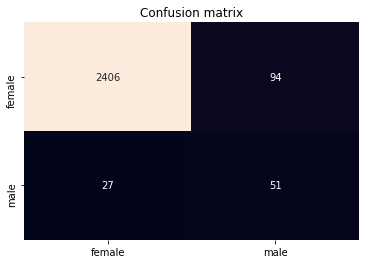

Классификатор в более половины случаев ошибается в определении мужских имен


In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

sns.heatmap(data=confusion_matrix(y_test, predicted), annot=True, fmt="d", cbar=False, xticklabels=['female', 'male'], yticklabels=['female', 'male'])
plt.title("Confusion matrix")
plt.show()
print("Классификатор в более половины случаев ошибается в определении мужских имен")

##  Часть 3. Нейронная сеть


Используйте  реккурентную нейронную сеть с  LSTM для решения задачи. В ней может быть несколько слоев с LSTM, несколько слоев c Bidirectional(LSTM).  У нейронной сети один выход, определяющий класс имени. 

Представление имени для классификации в этом случае: бинарная матрица размера (количество букв в алфавите $\times$ максимальная длина имени). Обозначим его через $x$. Если первая буква имени a, то $x[1][1] = 1$, если вторая – b, то  $x[2][1] = 1$.  

Не забудьте про регуляризацию нейронной сети дропаутами. 

Сравните результаты классификации разными методами. Какой метод лучше и почему?

Сравните результаты, получаемые при разных значениях дропаута, разных числах узлов на слоях нейронной сети по $F$-мере и аккуратности. В каких случаях нейронная сеть ошибается?

Если совсем не получается запрограммировать нейронную сеть самостоятельно, обратитесь к туториалу тут: https://github.com/divamgupta/lstm-gender-predictor

In [37]:
from __future__ import print_function
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM, Dropout
from keras.optimizers import RMSprop
from keras.utils.data_utils import get_file
from keras import backend as K
import tensorflow as tf
import numpy as np
import random
import sys

In [14]:
chars = set(  "".join(female.name) + "".join(male.name)  )
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))
print('total chars:', len(chars))

total chars: 55


In [15]:
train.shape

(5000,)

In [16]:
totalEntriesTrain = len(train)
maxlen = len(max( train , key=len))
print('total entries:', totalEntriesTrain)
print('max lengh:', maxlen)

total entries: 5000
max lengh: 15


In [17]:
totalEntriesTest = len(test)
maxlen = len(max( test , key=len))
print('total entries:', totalEntriesTest)
print('max lengh:', maxlen)

total entries: 2578
max lengh: 15


In [18]:
y_train_dum = pd.get_dummies(y_train)
y_train_dum.columns = ['female', 'male']
y_test_dum = pd.get_dummies(y_test)
y_test_dum.columns = ['female', 'male']
y_train_dum

,female,male
808,0,1
1193,0,1
761,0,1
318,0,1
2470,0,1
2564,0,1
812,0,1
1684,0,1
1089,0,1
1565,0,1


In [19]:
X_train = np.zeros((totalEntriesTrain , maxlen, len(chars) ), dtype=np.bool)
y_train = np.zeros((totalEntriesTrain , 2 ), dtype=np.bool)
X_test = np.zeros((totalEntriesTest , maxlen, len(chars) ), dtype=np.bool)
y_test = np.zeros((totalEntriesTest , 2 ), dtype=np.bool)

In [20]:
for i, name in enumerate(train):
    for t, char in enumerate(name):
        X_train[i, t, char_indices[char]] = 1
    y_train[i, 0] = y_train_dum['female'].iloc[i]
    y_train[i, 1] = y_train_dum['male'].iloc[i]

In [21]:
for i, name in enumerate(test):
    for t, char in enumerate(name):
        X_test[i, t, char_indices[char]] = 1
    y_test[i, 0] = y_test_dum['female'].iloc[i]
    y_test[i, 1] = y_test_dum['male'].iloc[i]

In [22]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(5000, 15, 55)
(5000, 2)
(2578, 15, 55)
(2578, 2)


In [45]:
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.
        Only computes a batch-wise average of recall.
        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(tf.convert_to_tensor(y_true * y_pred, np.float32), 0, 1)))
        possible_positives = K.sum(K.round(K.clip(tf.convert_to_tensor(y_true, np.float32), 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall
    def precision(y_true, y_pred):
        """Precision metric.
        Only computes a batch-wise average of precision.
        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(tf.convert_to_tensor(y_true * y_pred, np.float32), 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(tf.convert_to_tensor(y_pred, np.float32), 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall))

In [26]:
model = Sequential()
model.add(LSTM(512, return_sequences=True, input_shape=(maxlen, len(chars))))
model.add(Dropout(0.2))
model.add(LSTM(512, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(2))
model.add(Activation('softmax'))
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy', f1])

In [27]:
json_string = model.to_json()

with open("model2.json", "w") as text_file:
    text_file.write(json_string)

In [28]:
%%time
model.fit(X_train, y_train, batch_size=16, epochs=50)

Epoch 1/50
5000/5000 [==============================] - 209s 42ms/step - loss: 0.5811 - acc: 0.7114 - f1: 0.7114
Epoch 2/50
5000/5000 [==============================] - 203s 41ms/step - loss: 0.5065 - acc: 0.7540 - f1: 0.7540
Epoch 3/50
5000/5000 [==============================] - 202s 40ms/step - loss: 0.4676 - acc: 0.7748 - f1: 0.7748
Epoch 4/50
5000/5000 [==============================] - 199s 40ms/step - loss: 0.4249 - acc: 0.8076 - f1: 0.8076
Epoch 5/50
5000/5000 [==============================] - 203s 41ms/step - loss: 0.4011 - acc: 0.8202 - f1: 0.8202
Epoch 6/50
5000/5000 [==============================] - 203s 41ms/step - loss: 0.3775 - acc: 0.8292 - f1: 0.8292
Epoch 7/50
5000/5000 [==============================] - 200s 40ms/step - loss: 0.3625 - acc: 0.8400 - f1: 0.8400
Epoch 8/50
5000/5000 [==============================] - 202s 40ms/step - loss: 0.3486 - acc: 0.8514 - f1: 0.8514
Epoch 9/50
5000/5000 [==============================] - 201s 40ms/step - loss: 0.3370 - acc: 0.8

In [31]:
model.save_weights('my_model2_weights.h5')

In [47]:
score = model.evaluate(X_test, y_test, batch_size=16)
print("score:" , score)

2578/2578 [==============================] - 32s 12ms/step
score: [0.099121306166075521, 0.98138091543832429, 0.98138091543832429]
